In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def circle_points_torch(radius, num_points):
    """
    Generate coordinates of points on the circumference of a circle using PyTorch.

    Parameters:
    radius (float): The radius of the circle.
    num_points (int): The number of points to generate on the circumference.

    Returns:
    torch.Tensor: A tensor of shape (num_points, 2) containing the coordinates of the points.
    """
    # Create a tensor of angles evenly spaced around the circle
    angles = torch.linspace(0, 2 * torch.pi, num_points)
    
    # Calculate the x and y coordinates for each point
    x = radius * torch.cos(angles)
    y = radius * torch.sin(angles)
    norm= torch.sqrt( x**2 + y**2 )
    n_x = x / norm
    n_y = y / norm
    points = torch.stack((x, y,n_x,n_y), dim=1)
    return points

def draw_p(l):
    for elem in l:
        plt.scatter(elem[0],elem[1],color="black")

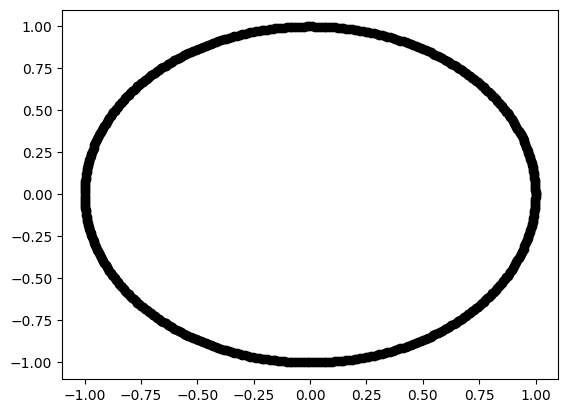

In [3]:
points_c=circle_points_torch(radius=1,num_points=500)
draw_p(points_c)

In [4]:
def get_borders(points):
    min_x=torch.min(points[:,0])
    max_x=torch.max(points[:,0])
    min_y=torch.min(points[:,1])
    max_y=torch.max(points[:,1])
    
    sep_x=torch.sqrt((max_x-min_x)**2)
    sep_y=torch.sqrt((max_y-min_y)**2)
    
    width=max(sep_x,sep_y)
    
    return (min_x,min_x+width,min_y,min_y+width)
    

def create_quadtree(dico,tmp_depth,depth,points,borders,label):
    min_x=borders[0]
    max_x=borders[1]
    min_y=borders[2]
    max_y=borders[3]
    
    sep_x=min_x+torch.sqrt((max_x-min_x)**2)/2.0
    sep_y=min_y+torch.sqrt((max_y-min_y)**2)/2.0
    
    
    
    
    mask=(points[:,0]<= sep_x) & (points[:,1]> sep_y)
    hg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]> sep_y)
    hd= points[mask]
    mask=(points[:,0]<= sep_x) & (points[:,1]<= sep_y)
    bg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]<= sep_y)
    bd= points[mask]
    
    
    gx=min_x
    gy=sep_y
    dx=sep_x
    dy=max_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"1"]=(tmp_depth,tmp_oc,dx-gx,border,hg)
    
    if (hg.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hg.clone(),border,label+"1")
    
    gx=sep_x
    gy=sep_y
    dx=max_x
    dy=max_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"2"]=(tmp_depth,tmp_oc,dx-gx,border,hd)
    
    if (hd.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hd.clone(),border,label+"2")
    
    gx=min_x
    gy=min_y
    dx=sep_x
    dy=sep_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"3"]=(tmp_depth,tmp_oc,dx-gx,border,bg)
    
    
    if (bg.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bg.clone(),border,label+"3")
    
    gx=sep_x
    gy=min_y
    dx=max_x
    dy=sep_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    

    dico[label+"4"]=(tmp_depth,tmp_oc,dx-gx,border,bd)
    
    
    if (bd.shape[0]>1) and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bd.clone(),border,label+"4")
    
    
    
    
def draw_quadtree(dico):
    fig = plt.figure()
    
    for node in dico:
        depth,_,_,border,l_points=dico[node]
        gx,dx,gy,dy=border
        
        
        if depth==0:
            draw_p(l_points)
        
        plt.plot([gx,dx],[gy,gy],color="blue")
        plt.plot([gx,dx],[dy,dy],color="blue")
        plt.plot([gx,gx],[dy,gy],color="blue")
        plt.plot([dx,dx],[dy,gy],color="blue")
    
    
    

In [5]:
dico=dict()
bord=get_borders(points_c)
create_quadtree(dico,0,15,points_c,bord,"")

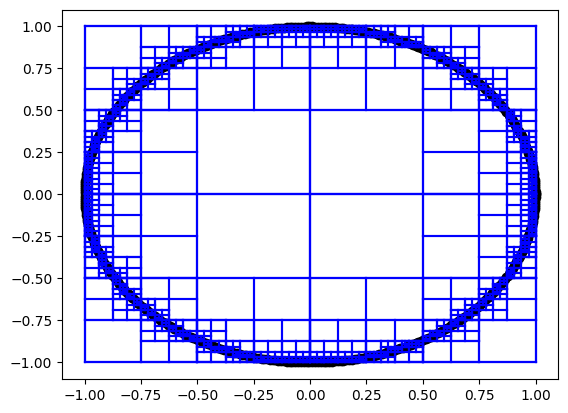

In [6]:
draw_quadtree(dico)

In [7]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

s_p=points_c[:,:2]


def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,4))
    o_s=torch.ones((nb_s,4,4)) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,l_points=dico[node]
            
            for p in l_points:
                s_p[cpt_p]=p.clone()
                gx,dx,gy,dy=dico[node[:-1]][-2]

                tmp_o_vec=torch.empty((4,4))
                for idx_nbgr in range(1,5):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    

                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1 - u)*v
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1 - u)*(1 - v)
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1 - v)
                
                o_s[cpt_p]=tmp_o_vec.clone()
                cpt_p+=1
    return s_p,o_s
#s_p : (50,4)
#o_s : (50,4,3)

                
                
            
            
s_p,o_s=get_os(points_c.shape[0],dico,5)

#print(o_s.shape)

def get_alpha(s_p,o_s):
    #(100,4,2)
    tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=s_p[:,:2]
    tmp_mat_sp[:,1,:]=s_p[:,:2]
    tmp_mat_sp[:,2,:]=s_p[:,:2]
    tmp_mat_sp[:,3,:]=s_p[:,:2]

    #RMSE
    return torch.sum(torch.sqrt((tmp_mat_sp-o_s[:,:,:2])**2),dim=2)

def get_Fo(o_s,q):
    

    arg_f=tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=q.clone()
    tmp_mat_sp[:,1,:]=q.clone()
    tmp_mat_sp[:,2,:]=q.clone()
    tmp_mat_sp[:,3,:]=q.clone()
    
    w=o_s[:,:,2].view((o_s.shape[0],o_s.shape[1],1))
    
    
    tmp_mat_sp=(tmp_mat_sp-o_s[:,:,:2])/w
    
    tmp_mat_sp=torch.where(torch.abs(tmp_mat_sp)<0.5,1,0)
    
    tmp_mat_sp=torch.prod(tmp_mat_sp,dim=2)**3
    w=o_s[:,:,2].view((o_s.shape[0],o_s.shape[1]))
    
    return tmp_mat_sp*(1/w**3)  


D=10
l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_q(q,l_o,l_s):
    q_vec=torch.empty((l_o.shape[0],4,2))
    q_vec[:,:,0]=q[0]
    q_vec[:,:,1]=q[1]
    
    q_vec[:,:,0]-=l_o[:,:,2]
    q_vec[:,:,0]/=l_o[:,:,1]
    q_vec[:,:,1]-=l_o[:,:,3]
    q_vec[:,:,1]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=2)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    
    res=torch.empty((l_o.shape[0],4,2))
    res[:,0]=l_s[:,2:]
    res[:,1]=l_s[:,2:]
    res[:,2]=l_s[:,2:]
    res[:,3]=l_s[:,2:]
    
    res[:,0,0]*=test[:,0]
    res[:,0,1]*=test[:,0]
    res[:,1,0]*=test[:,1]
    res[:,1,1]*=test[:,1]
    res[:,2,0]*=test[:,2]
    res[:,2,1]*=test[:,2]
    res[:,3,0]*=test[:,3]
    res[:,3,1]*=test[:,3]
    res=torch.sum(res,dim=(0,1))
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )
q=torch.ones(2)
q[0]=-1.
q[1]=0


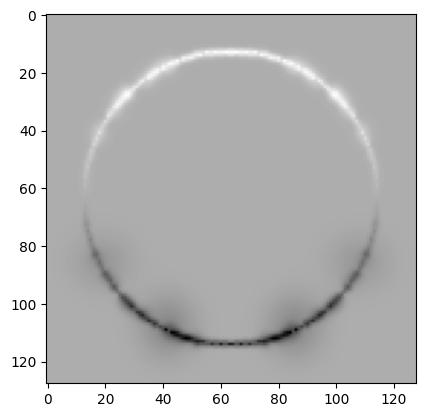

In [8]:
#octree depth
D=8
#grid resolution
n_p=128
#Average density for adaptative depth

image_res=torch.zeros((n_p,n_p,2))
vec=torch.linspace(-1.25,1.25,n_p)


s_p=points_c[:,:2]
l_s,l_o=get_os(s_p.shape[0],dico,D)



for i in range(len(vec)):
    for j in range(len(vec)):
        coords=torch.empty(2)
        coords[0]=vec[i]
        coords[1]=vec[j]
        tmp=get_V_q(coords,l_o,l_s)
        image_res[i][j]=tmp

plt.imshow(torch.sqrt(image_res[:,:,0]**2+image_res[:,:,1]**2),cmap="Greys")
plt.imshow(image_res[:,:,0],cmap="Greys")

In [108]:
def get_V_vec(img,l_o,l_s):
    #img: 32,32,2
    #->32,32,500,4,2
    
    q_vec=torch.clone(img)
    q_vec=q_vec.unsqueeze(2)
    q_vec=q_vec.unsqueeze(3)
    q_vec=q_vec.repeat(1,1,l_o.shape[0],4,1)
    
    q_vec[:,:,:,:,0]-=l_o[:,:,2]
    q_vec[:,:,:,:,0]/=l_o[:,:,1]
    q_vec[:,:,:,:,1]-=l_o[:,:,3]
    q_vec[:,:,:,:,1]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=4)/(1.5**2))
    

    tmp_Lo=l_o.clone().unsqueeze(0).unsqueeze(0)
    tmp_Lo=tmp_Lo.repeat(img.shape[0],img.shape[0],1,1,1)
    test=(test*tmp_Lo[:,:,:,:,0]).view(img.shape[0],img.shape[0],l_o.shape[0],4,1).repeat(1,1,1,1,2)
    print(test.shape)

    #res=torch.empty((l_o.shape[0],4,2))
    #res[:,0]=l_s[:,2:]

    res=l_o[:,:,2:].clone().unsqueeze(0).unsqueeze(0).repeat(img.shape[0],img.shape[0],1,1,1)
    res=torch.sum(res*test,dim=(2,3))
    
    
    return res

def compute_laplacian(X):
    # Compute the Laplacian using finite differences
    laplacian = -4 * X
    laplacian[:-1, :] += X[1:, :]  # X_{i+1,j}
    laplacian[1:, :] += X[:-1, :]  # X_{i-1,j}
    laplacian[:, :-1] += X[:, 1:]  # X_{i,j+1}
    laplacian[:, 1:] += X[:, :-1]  # X_{i,j-1}
    return laplacian


def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :] += (V[2:, :, 0] - V[:-2, :, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1] += (V[:, 2:, 1] - V[:, :-2, 1]) / 2
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :] += (V[1, :, 0] - V[0, :, 0])
    div_V[-1, :] += (V[-1, :, 0] - V[-2, :, 0])
    div_V[:, 0] += (V[:, 1, 1] - V[:, 0, 1])
    div_V[:, -1] += (V[:, -1, 1] - V[:, -2, 1])

    return div_V

torch.Size([256, 256, 500, 4, 2])


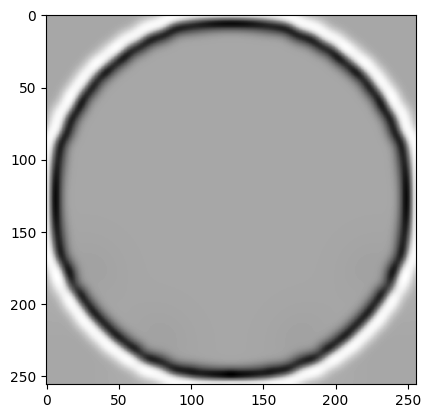

In [126]:
D=5
l_s,l_o=get_os(s_p.shape[0],dico,D)

borders=get_borders(points_c)

min_x=borders[0].item()
max_x=borders[1].item()
min_y=borders[2].item()
max_y=borders[3].item()

X, Y = np.mgrid[min_x:max_x:256j, min_y:max_y:256j]

X=torch.from_numpy(X)
Y=torch.from_numpy(Y)

img=torch.empty((256,256,2))
img[:,:,0]=X
img[:,:,1]=Y


img=get_V_vec(img,l_o,l_s)
#plt.imshow(torch.sqrt(img[:,:,0]**2+img[:,:,1]**2),cmap="Greys")

grad=compute_divergence(img)
plt.imshow(grad,cmap="Greys")




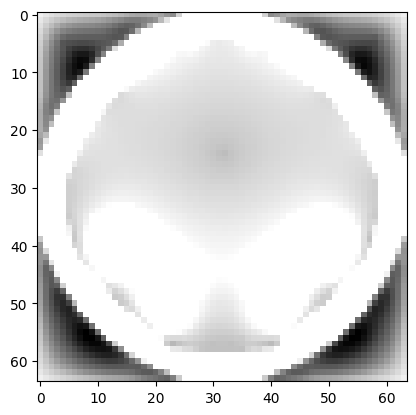

In [107]:
import torch.optim as optim

def grad_loss(img,V):
    
    
    return torch.sum(torch.abs(compute_laplacian(img)-V))


def fit(V):
    optimizer=optim.LBFGS([torch.zeros(0)],lr=0.8, max_iter=50000)
    eps_b=V.clone()
    eps_b.requires_grad = True
    optimizer.param_groups[0]['params'][0] = eps_b

    def closure():
        optimizer.zero_grad()
        loss=grad_loss(eps_b,V)
        loss.backward(retain_graph=True)
        return loss
    loss=optimizer.step(closure)
    
    return eps_b

eps=fit(grad)

eps=eps.detach()
plt.imshow(torch.sqrt(eps),cmap="Greys")

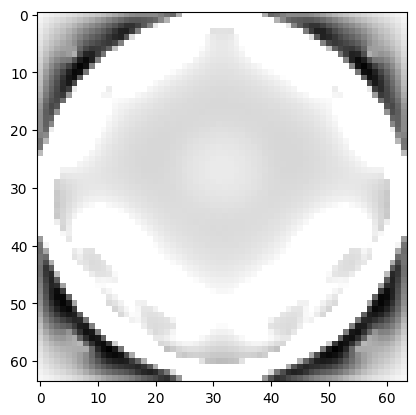

In [101]:
def grad_loss_SGD(img,V):
    

    return torch.mean((torch.abs(compute_laplacian(img)-V)))


def fit_SGD(V):
    eps_b=V.clone()
    eps_b.requires_grad = True
    optimizer=optim.SGD([torch.zeros(0)], lr=0.9)
    optimizer.param_groups[0]['params'][0] = eps_b

    for _ in range(50000):
        optimizer.zero_grad()
        loss=grad_loss_SGD(eps_b,V)
        loss.backward()
        optimizer.step()
    return eps_b
        

eps=fit_SGD(grad)   
eps=eps.detach()
plt.imshow(torch.sqrt(eps),cmap="Greys")

In [ ]:
def draw_circle(matrix_size, center, radius):
    """
    Draws a circle in a 2D matrix of zeros.

    Parameters:
    matrix_size (tuple): The size of the 2D matrix (height, width).
    center (tuple): The (x, y) coordinates of the circle's center.
    radius (int): The radius of the circle.

    Returns:
    torch.Tensor: A 2D matrix with a circle drawn in it.
    """
    # Create a 2D matrix of zeros
    matrix = torch.zeros(matrix_size)

    # Iterate over each element in the matrix
    for y in range(matrix_size[0]):
        for x in range(matrix_size[1]):
            # Check if the current element is inside the circle
            if (x - center[0])**2 + (y - center[1])**2 <= radius**2:
                matrix[y, x] = 1

            
    return matrix

# Example usage
matrix_size = (100, 100)  # Size of the matrix
center = (50, 50)         # Center of the circle
radius = 40         # Radius of the circle

circle_matrix = draw_circle(matrix_size, center, radius)
plt.imshow(circle_matrix)

In [ ]:
test_1=get_grad_first(circle_matrix.view(100,100,1))

fig = plt.figure(constrained_layout=True,figsize=(10,15))
axs = (fig.subplots(1, 2, sharex=False, sharey=False))

axs[0].imshow(test_1[:,:,0],cmap='gray')
axs[1].imshow(test_1[:,:,1],cmap='gray')


In [ ]:
test_2=get_grad_sec(test_1)
print(test_2.shape)
fig = plt.figure(constrained_layout=True,figsize=(10,15))
axs = (fig.subplots(1, 4, sharex=False, sharey=False))

axs[0].imshow(test_2[:,:,0],cmap='gray')
axs[1].imshow(test_2[:,:,1],cmap='gray')
axs[2].imshow(test_2[:,:,2],cmap='gray')
axs[3].imshow(test_2[:,:,3],cmap='gray')

In [ ]:
grad=get_grad_sec(img)

fig = plt.figure(constrained_layout=True,figsize=(10,15))
axs = (fig.subplots(1, 4, sharex=False, sharey=False))

axs[0].imshow(grad[:,:,0],cmap='gray')
axs[1].imshow(grad[:,:,1],cmap='gray')
axs[2].imshow(grad[:,:,2],cmap='gray')
axs[3].imshow(grad[:,:,3],cmap='gray')




In [ ]:
import numpy as np
from scipy.integrate import dblquad
from math import exp, sqrt, pi

def gaussian(x, y, x0, y0, sigma):
    """Return the value of a Gaussian function centered at (x0, y0) with standard deviation sigma."""
    return exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

def gradient_of_gaussian(x, y, x0, y0, sigma):
    """Return the gradient vector of a Gaussian function at point (x, y)."""
    gx = -(x - x0) * gaussian(x, y, x0, y0, sigma) / sigma**2
    gy = -(y - y0) * gaussian(x, y, x0, y0, sigma) / sigma**2
    return np.array([gx, gy])

def inner_product_of_gradients(xa, ya, xb, yb, sigma):
    """Compute the inner product of the gradients of two Gaussian functions."""
    
    # Define the limits of integration. Since Gaussians decay rapidly, we can integrate over a finite range
    # where the Gaussian functions have significant values. Here we use 3 standard deviations from the centers.
    limit = 3 * sigma
    x_min, x_max = min(xa, xb) - limit, max(xa, xb) + limit
    y_min, y_max = min(ya, yb) - limit, max(ya, yb) + limit

    # Define the inner product integrand
    def integrand(x, y):
        grad_a = gradient_of_gaussian(x, y, xa, ya, sigma)
        grad_b = gradient_of_gaussian(x, y, xb, yb, sigma)
        return np.dot(grad_a, grad_b)
    
    # Perform the double integral
    result, _ = dblquad(
        lambda x, y: integrand(x, y),
        x_min, x_max,
        lambda x: y_min, lambda x: y_max
    )
    
    return result

# Example usage:
sigma = 1.0  # Standard deviation for the Gaussian functions
xa, ya = 0, 0  # Center of B_a
xb, yb = 1, 1  # Center of B_b

inner_product = inner_product_of_gradients(xa, ya, xb, yb, sigma)
inner_product

In [119]:
def get_inner_productB(xa, ya, xb, yb,Width):
    xg=(xa-Width/2.0).item()
    xd=(xa+Width/2.0).item()
    yg=(ya-Width/2.0).item()
    yd=(ya+Width/2.0).item()
    X, Y = np.mgrid[xg:xd:64j, yg:yd:64j]

    X=torch.from_numpy(X)
    Y=torch.from_numpy(Y)
    
    idxs=torch.empty((64,64,2))
    idxs[:,:,0]=X
    idxs[:,:,1]=Y

    dx = (xd - xg) / (64)
    dy = (yd - yg) / (64)
    area_per_cell = dx * dy

    

    res_A = torch.exp(-((X - xa)**2 + (Y - ya)**2) / (Width * 1.5)**2)
    res_B = torch.exp(-((X - xb)**2 + (Y - yb)**2) / (Width * 1.5)**2)
    return torch.sum(res_A*res_B*area_per_cell)

In [120]:
D=10
l_s,l_o=get_os(s_p.shape[0],dico,D)

borders=get_borders(points_c)

min_x=borders[0].item()
max_x=borders[1].item()
min_y=borders[2].item()
max_y=borders[3].item()


Width=(max_y-min_y)/5
X, Y = np.mgrid[min_x:max_x:5j, min_y:max_y:5j]

X=torch.from_numpy(X)
Y=torch.from_numpy(Y)

idxs=torch.empty((5,5,2))
A=torch.empty((5,5))
idxs[:,:,0]=X
idxs[:,:,1]=Y

for i in range(5):
    for j in range(5):
        A[i,j]=get_inner_productB(idxs[i,i,0],idxs[i,i,1],idxs[i,j,0],idxs[i,j,1],Width)






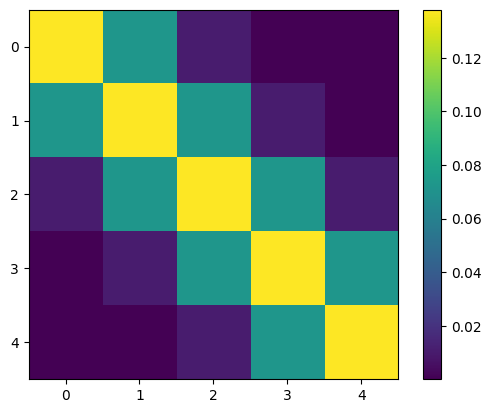

In [121]:
plt.imshow(A)
plt.colorbar()